In [1]:
import spherical_inr as sph
import matplotlib.pyplot as plt
import torch
import s2fft
import utils
import numpy as np

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [2]:
class ToCart(torch.nn.Module):
    def forward(self, x):
        return sph.transforms.tp_to_r3(x)

In [3]:
shnet = torch.nn.Sequential(
    ToCart(),
    sph.NormalizedIrregularHerglotzPE(L = 10, input_dim=3)
)

In [4]:
phi, theta, (nlon, nlat) = utils.sample_s2(L = 20, sampling = "gl")
x = torch.stack([theta.flatten(), phi.flatten()], dim=-1)

In [5]:
y = shnet(x).reshape(nlat, nlon, -1)

In [6]:
sh_transforms = []

for i in range(y.size(-1)):
    yi = y[..., i].detach().numpy()
    sh_transform = s2fft.forward_numpy(yi, L = 20, sampling = "gl")
    sh_transforms.append(sh_transform)

sh_transforms = np.sum(sh_transforms, axis=0)

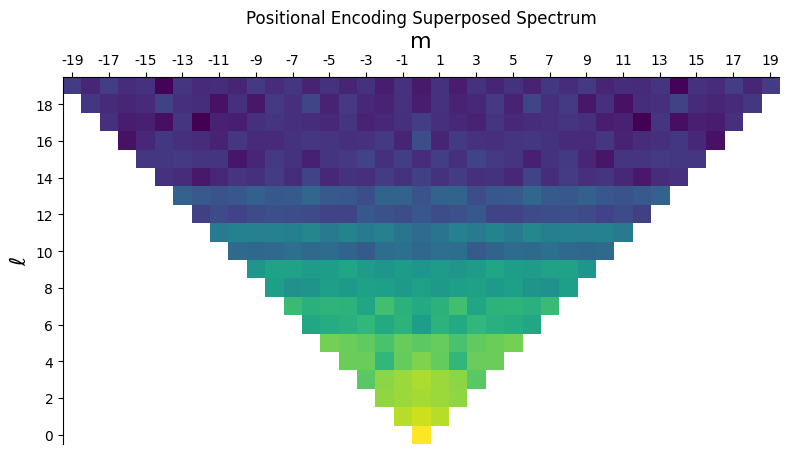

In [7]:
utils.plot_SHT_coeffs(sh_transforms, ticks_m=2, ticks_l=2)
plt.title("Positional Encoding Superposed Spectrum")
plt.show()